In [1]:
import numpy as np 
import pandas as pd 
import os

In [2]:
!pip install segmentation_models --no-index --find-links=file:///kaggle/input/seg-models-offline

Looking in links: file:///kaggle/input/seg-models-offline
Processing /kaggle/input/seg-models-offline/segmentation_models-1.0.1-py3-none-any.whl
Processing /kaggle/input/seg-models-offline/Keras_Applications-1.0.8-py3-none-any.whl
Processing /kaggle/input/seg-models-offline/image_classifiers-1.0.0-py3-none-any.whl
Processing /kaggle/input/seg-models-offline/efficientnet-1.0.0-py3-none-any.whl


In [3]:
import segmentation_models as sm
sm.set_framework('tf.keras')

sm.framework()
from segmentation_models import Unet

Segmentation Models: using `keras` framework.


In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import keras
import glob
from tensorflow.keras.utils import Sequence
from keras import backend as K
from keras.losses import binary_crossentropy
import tensorflow as tf


from keras import layers
from keras.layers import BatchNormalization

In [5]:
train_df = pd.read_csv("../input/hubmap-organ-segmentation/train.csv")
test_df = pd.read_csv("../input/hubmap-organ-segmentation/test.csv")


In [6]:
train_df

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female
...,...,...,...,...,...,...,...,...,...,...
346,9517,kidney,HPA,3000,3000,0.4,4,1611763 11 1614753 29 1617750 35 1620746 43 16...,61.0,Male
347,9769,kidney,HPA,3070,3070,0.4,4,4030400 28 4033466 34 4036526 48 4039594 54 40...,28.0,Male
348,9777,largeintestine,HPA,3000,3000,0.4,4,538473 13 541468 22 544463 30 547461 35 550459...,84.0,Male
349,9791,kidney,HPA,3000,3000,0.4,4,334733 33 337729 43 340729 43 343725 51 346723...,28.0,Male


In [7]:
train_df['img_height'].value_counts()

3000    326
2631      2
2416      2
2942      2
2790      2
2764      2
2654      2
2539      1
2680      1
2727      1
2308      1
2867      1
2783      1
2869      1
2760      1
2630      1
2511      1
2593      1
2675      1
3070      1
Name: img_height, dtype: int64

In [8]:
train_df['img_width'].value_counts()

3000    326
2631      2
2416      2
2942      2
2790      2
2764      2
2654      2
2539      1
2680      1
2727      1
2308      1
2867      1
2783      1
2869      1
2760      1
2630      1
2511      1
2593      1
2675      1
3070      1
Name: img_width, dtype: int64

In [9]:
pd.crosstab(train_df['img_height'],train_df['img_width'])

#Height=Width for all images

img_width,2308,2416,2511,2539,2593,2630,2631,2654,2675,2680,2727,2760,2764,2783,2790,2867,2869,2942,3000,3070
img_height,,,,,,,,,,,,,,,,,,,,
2308,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2416,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2511,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2539,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2593,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2630,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2631,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
2654,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0
2675,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [10]:
print('Minimum width:',train_df['img_width'].min())
print('Maximum width:',train_df['img_width'].max())
print('Minimum height:',train_df['img_height'].min())
print('Maximum height:',train_df['img_height'].max())

Minimum width: 2308
Maximum width: 3070
Minimum height: 2308
Maximum height: 3070


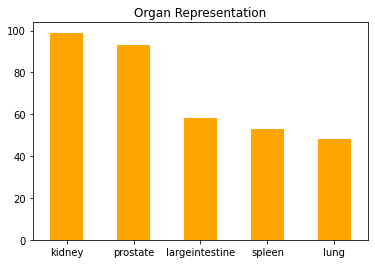

In [11]:
train_df['organ'].value_counts().plot(kind='bar',color='orange')
plt.title('Organ Representation')
plt.xticks(rotation=360)
plt.show()

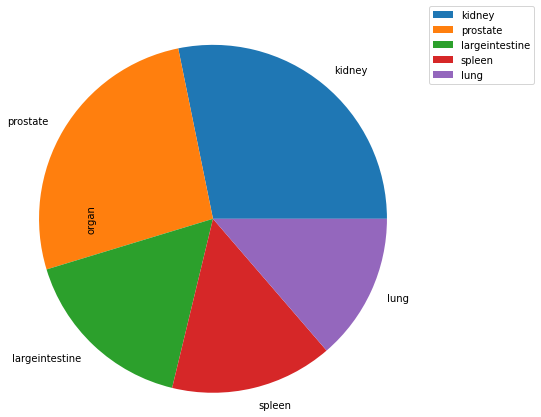

In [12]:
train_df['organ'].value_counts().plot(kind='pie',radius=2)
plt.legend(bbox_to_anchor=(1, 1., 1, 0.5))
plt.show()

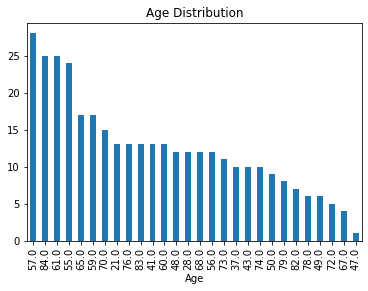

In [13]:
train_df['age'].value_counts().plot(kind='bar')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.show()


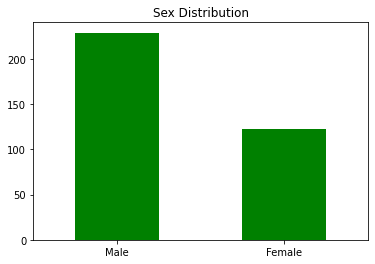

In [14]:
train_df['sex'].value_counts().plot(kind='bar',color='green')
plt.title('Sex Distribution')
plt.xticks(rotation=360)
plt.show()

In [15]:
train_df['pixel_size'].value_counts()

0.4    351
Name: pixel_size, dtype: int64

In [16]:
train_df['tissue_thickness'].value_counts()

4    351
Name: tissue_thickness, dtype: int64

In [17]:
#helper functions
def rle_decoder(n,df= train_df):
    
    ht = int(df['img_height'][n])
    wt = int(df['img_width'][n])
    
    mask = np.zeros((ht * wt),dtype = np.uint8)
    values = np.asarray(df['rle'][n].split(" "),dtype='int')
    
    start_pt = values[::2] - 1
    length = values[1::2]
    end_pt = start_pt + length
    
    for start, end in zip(start_pt, end_pt):
        mask[start:end] = 1
    

    mask = mask.reshape(wt,ht)
    mask = mask.T
    mask = mask.astype(np.uint8)
    return mask

def mask_to_rle(img):
    pixels = img.T.flatten()
    pixels = np.concatenate([[0],pixels,[0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] 
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

**Plotting Images**

Before plotting, let us merge the train_images file path to our train.csv dataframe

In [18]:
train_img_path = glob.glob('../input/hubmap-organ-segmentation/train_images/*')
paths_df = pd.DataFrame(columns=['paths'])
paths_df['paths'] = train_img_path

paths_df['id'] = paths_df['paths'].apply(lambda x: x.split('/')[-1].replace('.tiff',"")).astype('int')

train_df = train_df.merge(paths_df,on='id')


In [19]:
train_df

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,paths
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,../input/hubmap-organ-segmentation/train_image...
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,../input/hubmap-organ-segmentation/train_image...
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,../input/hubmap-organ-segmentation/train_image...
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,../input/hubmap-organ-segmentation/train_image...
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,../input/hubmap-organ-segmentation/train_image...
...,...,...,...,...,...,...,...,...,...,...,...
346,9517,kidney,HPA,3000,3000,0.4,4,1611763 11 1614753 29 1617750 35 1620746 43 16...,61.0,Male,../input/hubmap-organ-segmentation/train_image...
347,9769,kidney,HPA,3070,3070,0.4,4,4030400 28 4033466 34 4036526 48 4039594 54 40...,28.0,Male,../input/hubmap-organ-segmentation/train_image...
348,9777,largeintestine,HPA,3000,3000,0.4,4,538473 13 541468 22 544463 30 547461 35 550459...,84.0,Male,../input/hubmap-organ-segmentation/train_image...
349,9791,kidney,HPA,3000,3000,0.4,4,334733 33 337729 43 340729 43 343725 51 346723...,28.0,Male,../input/hubmap-organ-segmentation/train_image...


Display images with and without masks


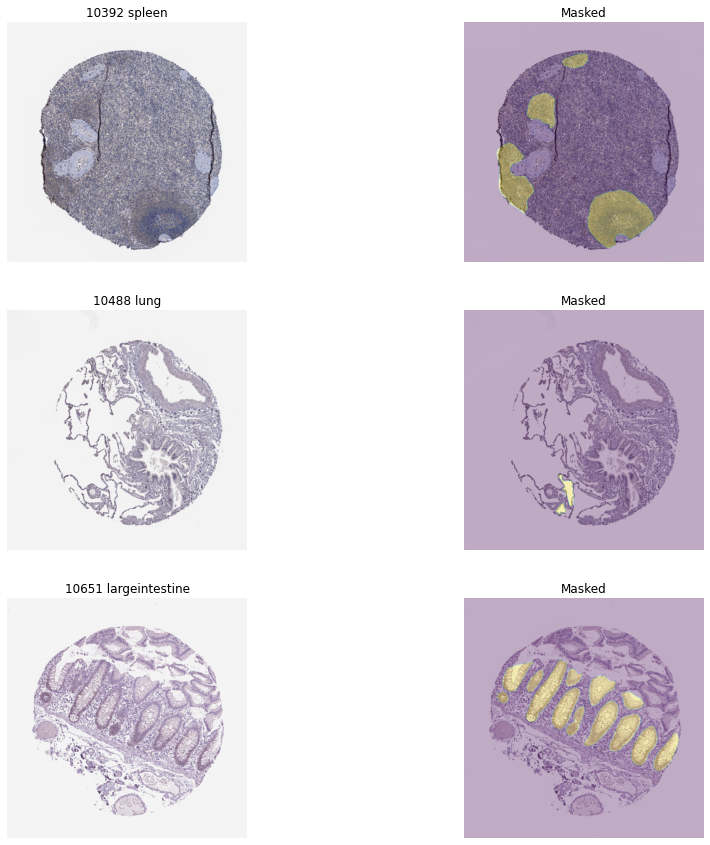

In [20]:
plt.figure(figsize=(15,15))
n = [2,3,6]
a = 1
for i in n:
    img1 = Image.open(train_df['paths'][i])
    img1 = np.array(img1)
    plt.subplot(3,2,a)
    plt.title(str(train_df['id'][i])+' '+str(train_df['organ'][i]))
    plt.axis('off')
    plt.imshow(img1,alpha=1)
    a = a + 1

    plt.subplot(3,2,a)
    plt.imshow(img1)
    plt.subplot(3,2,a)
    plt.axis('off')
    plt.title('Masked')
    plt.imshow(rle_decoder(i,train_df),alpha=0.3)
    a = a + 1
    

In [21]:
def dice_coef(y_true, y_pred, smooth=1):
    # flatten
    y_true_f = K.flatten(K.cast(y_true, np.float32))
    #y_pred_f = K.flatten(K.cast(K.argmax(y_pred, axis=-1), np.float32))
    y_pred_f = K.flatten(K.cast(K.argmax(y_pred, axis=-1), np.float32))
    # compute numerator and denominator
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)
    # apply dice formula
    dice = K.mean((2.*intersection + smooth)/(union + smooth))
    return dice

def weighted_loss(y_true, y_pred):
    # Calculate the base loss
    ce = K.sparse_categorical_crossentropy(y_true, y_pred)
    # Apply the weights
    one_weight = 1.0
    zero_weight = 1e-2
    weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
    weight_vector = K.squeeze(weight_vector, axis=-1)
    weighted_ce = weight_vector * ce

    # Return the mean error
    return K.mean(weighted_ce)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)

**Building datagenerator**

In [22]:

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, df, batch_size=16, n_classes=5, shuffle=False,to_fit=True):
  
        'Initialization'
        self.df = df
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.df))
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size: (index+1)*self.batch_size]
        X = np.empty((self.batch_size,640,640,3),dtype=np.float32)
        y = np.empty((self.batch_size,640,640,1),dtype=np.uint8)
        
        if self.to_fit == True:
            
            for i, img_path in enumerate(self.df['paths'].iloc[indexes]):
                img = self.read_img(img_path)
                X[i,] = img
                dims = int(self.df['img_height'].iloc[indexes[i]])
                mask = self.get_mask(dims,indexes[i])
                y[i,] = mask
                
            
            return X, y
          
        else:
            for i, img_path in enumerate(self.df['paths'].iloc[indexes]):
                img = self.read_img(img_path)
                X[i,] = img
                
            return X
        
        
    def read_img(self, path):
        image =  Image.open(path)
        image = image.resize((640,640))
        image = np.asarray(image)
        image = image.astype(np.float32)
        return image/255
    
    def get_mask(self,dim,n):
    
        mask = np.zeros((dim * dim),dtype = np.uint8)
        values = np.asarray(self.df['rle'].iloc[n].split(" "),dtype='int')
    
        start_pt = values[::2] - 1
        length = values[1::2]
        end_pt = start_pt + length
    
        for start, end in zip(start_pt, end_pt):
            mask[start:end] = 1
    

        mask = mask.reshape(dim,dim)
        mask = mask.T
        mask = mask.astype(np.uint8)
        
        res = cv2.resize(mask, dsize=(640, 640))
        res = np.expand_dims(res, axis=-1)
        
        return res

In [23]:
from sklearn.model_selection import train_test_split

y = train_df['organ']
train,val = train_test_split(train_df,test_size=0.1,stratify=y)
train

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,paths
50,14674,largeintestine,HPA,3000,3000,0.4,4,1428727 8 1431725 12 1434723 31 1437721 35 144...,83.0,Male,../input/hubmap-organ-segmentation/train_image...
134,22236,spleen,HPA,3000,3000,0.4,4,1873727 96 1876725 100 1879717 112 1882712 122...,57.0,Male,../input/hubmap-organ-segmentation/train_image...
291,5317,prostate,HPA,2416,2416,0.4,4,2290569 1 2292984 2 2295399 3 2297815 3 230023...,48.0,Male,../input/hubmap-organ-segmentation/train_image...
314,7359,lung,HPA,3000,3000,0.4,4,4020786 16 4023785 22 4026784 27 4029782 31 40...,43.0,Female,../input/hubmap-organ-segmentation/train_image...
122,21129,kidney,HPA,3000,3000,0.4,4,1890665 9 1893659 19 1896655 25 1899653 29 190...,41.0,Female,../input/hubmap-organ-segmentation/train_image...
...,...,...,...,...,...,...,...,...,...,...,...
77,1690,prostate,HPA,3000,3000,0.4,4,946573 55 949572 58 952571 60 955566 74 955653...,61.0,Male,../input/hubmap-organ-segmentation/train_image...
308,6730,prostate,HPA,3000,3000,0.4,4,1360948 40 1363947 42 1366946 44 1369938 53 13...,57.0,Male,../input/hubmap-organ-segmentation/train_image...
100,19377,spleen,HPA,3000,3000,0.4,4,1444167 52 1447164 59 1450161 71 1453160 75 14...,21.0,Female,../input/hubmap-organ-segmentation/train_image...
114,2079,spleen,HPA,3000,3000,0.4,4,3558433 11 3561431 16 3564429 20 3567427 23 35...,82.0,Male,../input/hubmap-organ-segmentation/train_image...


In [24]:
train_gen = DataGenerator(df = train,shuffle=True,batch_size=2)
val_gen = DataGenerator(df = val,shuffle=True,batch_size=2)

In [25]:
model = Unet('efficientnetb7', input_shape=(640, 640, 3), encoder_weights='imagenet', activation='sigmoid',classes=1,encoder_freeze=True)



2022-08-20 12:58:15.187343: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 12:58:15.311981: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 12:58:15.312814: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 12:58:15.314721: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

258449408/258434480 [==============================] - 6s 0us/step


In [26]:
callbacks = [tf.keras.callbacks.ModelCheckpoint('unet_model', monitor="val_accuracy",save_best_only=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",patience = 5, mode='min',factor=0.1,min_lr=0.00001),
            tf.keras.callbacks.EarlyStopping(patience=7,monitor = 'val_loss')]

In [27]:
#model.summary()

In [28]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy',dice_coef])

In [29]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    use_multiprocessing=False,
    epochs=10
 )

2022-08-20 12:58:31.504568: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-08-20 12:58:59.479988: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


157/157 [==============================] - 201s 1s/step - loss: 0.2941 - accuracy: 0.8799 - dice_coef: 2.6411e-05 - val_loss: 0.2803 - val_accuracy: 0.9105 - val_dice_coef: 1.9959e-05
Epoch 2/10
157/157 [==============================] - 128s 814ms/step - loss: 0.1853 - accuracy: 0.9235 - dice_coef: 2.5153e-05 - val_loss: 0.2558 - val_accuracy: 0.8793 - val_dice_coef: 1.8428e-05
Epoch 3/10
157/157 [==============================] - 102s 646ms/step - loss: 0.1701 - accuracy: 0.9305 - dice_coef: 2.2538e-05 - val_loss: 0.1806 - val_accuracy: 0.9264 - val_dice_coef: 1.9353e-05
Epoch 4/10
157/157 [==============================] - 89s 565ms/step - loss: 0.1543 - accuracy: 0.9380 - dice_coef: 2.1873e-05 - val_loss: 0.3112 - val_accuracy: 0.9049 - val_dice_coef: 1.6431e-05
Epoch 5/10
157/157 [==============================] - 96s 608ms/step - loss: 0.1471 - accuracy: 0.9397 - dice_coef: 2.4630e-05 - val_loss: 0.2067 - val_accuracy: 0.9153 - val_dice_coef: 1.9315e-05
Epoch 6/10
157/157 [======

In [30]:
for layers in model.layers:
    layers.trainable = True
    
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [31]:
history = model.fit(train_gen,
                   validation_data = val_gen,
                   callbacks = callbacks,
                   epochs = 50)

Epoch 1/50
157/157 [==============================] - 183s 978ms/step - loss: 0.0934 - accuracy: 0.9646 - val_loss: 0.1339 - val_accuracy: 0.9529


2022-08-20 13:24:57.331910: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
157/157 [==============================] - 166s 1s/step - loss: 0.0851 - accuracy: 0.9674 - val_loss: 0.1440 - val_accuracy: 0.9406
Epoch 3/50
157/157 [==============================] - 157s 999ms/step - loss: 0.0782 - accuracy: 0.9703 - val_loss: 0.1260 - val_accuracy: 0.9549


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/50
157/157 [==============================] - 164s 1s/step - loss: 0.0725 - accuracy: 0.9728 - val_loss: 0.1371 - val_accuracy: 0.9535
Epoch 5/50
157/157 [==============================] - 158s 1s/step - loss: 0.0658 - accuracy: 0.9754 - val_loss: 0.1257 - val_accuracy: 0.9559


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/50
157/157 [==============================] - 159s 1s/step - loss: 0.0573 - accuracy: 0.9785 - val_loss: 0.1312 - val_accuracy: 0.9560


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/50
157/157 [==============================] - 155s 986ms/step - loss: 0.0569 - accuracy: 0.9784 - val_loss: 0.1489 - val_accuracy: 0.9403
Epoch 8/50
157/157 [==============================] - 161s 1s/step - loss: 0.0529 - accuracy: 0.9803 - val_loss: 0.1276 - val_accuracy: 0.9539
Epoch 9/50
157/157 [==============================] - 155s 982ms/step - loss: 0.0473 - accuracy: 0.9823 - val_loss: 0.1373 - val_accuracy: 0.9491
Epoch 10/50
157/157 [==============================] - 161s 1s/step - loss: 0.0447 - accuracy: 0.9830 - val_loss: 0.1397 - val_accuracy: 0.9521
Epoch 11/50
157/157 [==============================] - 157s 995ms/step - loss: 0.0426 - accuracy: 0.9838 - val_loss: 0.1352 - val_accuracy: 0.9538
Epoch 12/50
157/157 [==============================] - 165s 1s/step - loss: 0.0407 - accuracy: 0.9845 - val_loss: 0.1326 - val_accuracy: 0.9550


In [32]:
check_df = pd.DataFrame(train_df.iloc[0:3])
check_df

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,paths
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,../input/hubmap-organ-segmentation/train_image...
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,../input/hubmap-organ-segmentation/train_image...
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,../input/hubmap-organ-segmentation/train_image...


In [33]:
def preprocess_image(path):
    image = tf.keras.utils.load_img(path)
    original_shape = tf.keras.utils.img_to_array(image).shape
    image_processed = tf.keras.utils.img_to_array(tf.keras.utils.array_to_img(image).resize((512, 512)))/255
    return image_processed,original_shape

In [34]:
test_gen = DataGenerator(test_df,batch_size=1,to_fit=False)
check_gen = DataGenerator(check_df,batch_size=1,to_fit=False)

2022-08-20 14:04:41.331284: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.97GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


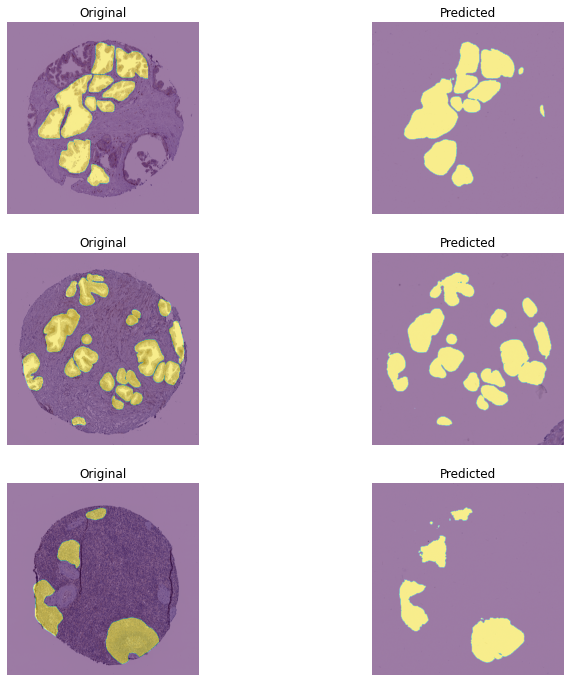

In [35]:

check_predictions = model.predict(check_gen)
check_mask = np.where(check_predictions > 0.5,1,0)
check_mask.shape

plt.figure(figsize=(12,12))
a = 1
for i in range(len(check_df)):
    
    img = Image.open(check_df['paths'][i])
    img = np.array(img)
    plt.subplot(3,2,a)
    plt.title('Original')
    plt.axis('off')
    plt.imshow(img)
    plt.subplot(3,2,a)
    plt.imshow(rle_decoder(i,check_df),alpha=0.5)
    
    
    plt.subplot(3,2,a+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Predicted')
    plt.subplot(3,2,a+1)
    plt.imshow(check_mask[i],alpha=0.5)
    
    a+=2

In [36]:
#test_df = pd.read_csv('../input/hubmap-organ-segmentation/test.csv')
#test_ids = test_df['id']
#test_dir = '../input/hubmap-organ-segmentation/test_images'

#ids = []
#rles = []
#for id in test_ids:
    #path = os.path.join(test_dir, f"{id}.tiff")
    #image,original_shape = preprocess_image(path)
    #pred = model.predict(np.expand_dims(image, axis=0))
    #pred_mask = np.where(pred > 0.5, 1, 0)[0]
    #resized_pred_mask = tf.keras.utils.array_to_img(pred_mask, scale=False).resize((original_shape[0], original_shape[1]), resample=0)
    #resized_pred_mask_array = tf.keras.utils.img_to_array(resized_pred_mask, dtype='uint8')
    #rle = mask_to_rle(resized_pred_mask_array)
    #ids.append(id)
    #rles.append(rle)
    
#submission_df = pd.DataFrame({'id':ids,'rle':rles})
#submission_df.to_csv('submission.csv', index=False)

In [37]:
#submission_df